# use vtorch220

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.vqa_dataset_from_pretrained import VQADatasetFromPretrained, load_dataset
from models.vqa_model_from_pretrained import VQAModelFromPretrained

from utils import trainer
import argparse
from utils.optimizer import ControlLR

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [3]:

# load data
train_data = load_dataset('dataset/vaq2.0.TrainImages.txt')
val_data = load_dataset('dataset/vaq2.0.DevImages.txt')
test_data = load_dataset('dataset/vaq2.0.TestImages.txt')

print(len(train_data), len(val_data), len(test_data))

# create mapping dict
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {cls_name:idx for idx, cls_name in enumerate(classes)}
idx_to_classes = {idx:cls_name for idx, cls_name in enumerate(classes)}


7846 1952 2022


In [4]:
def main(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    parser = argparse.ArgumentParser(description='Process some data with a given model')
    parser.add_argument('--visual-pretrained', default='google/vit-base-patch16-224', help='Name of images pretrained')
    parser.add_argument('--text-pretrained', default='roberta-base', help='Name of text pretrained')


    args, unknown = parser.parse_known_args()

    visual_pretrained = args.visual_pretrained
    text_pretrained = args.text_pretrained

    

    
    # create model, tokenizer, preprocessor
    model = VQAModelFromPretrained(
        visual_pretrained_name=visual_pretrained,
        text_pretrained_name=text_pretrained,
        n_classes=len(classes)
    )
    text_tokenizer = model.text_encoder.tokenizer
    image_preprocessor = model.visual_encoder.image_preprocessor
    model = model.to(device)
    
    # create datasets
    train_dataset = VQADatasetFromPretrained(train_data, classes_to_idx, image_preprocessor, text_tokenizer)
    val_dataset = VQADatasetFromPretrained(val_data, classes_to_idx, image_preprocessor, text_tokenizer)
    test_dataset = VQADatasetFromPretrained(test_data, classes_to_idx, image_preprocessor, text_tokenizer)
    

    
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    
    return model, train_loader, val_loader, test_loader, val_dataset




In [5]:
! nvidia-smi

Sat Jan 18 19:58:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.142                Driver Version: 550.142        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              7W /   80W |      18MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
#! kill -9 7540

In [5]:
# create dataloaders
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 32
model, train_loader, val_loader, test_loader, val_dataset = main(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


freezing google/vit-base-patch16-224 parameters


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


freezing roberta-base parameters


In [8]:
# sample
image, question, label = next(iter(val_loader))
print(image.shape, question.shape, label.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 512]) torch.Size([32])


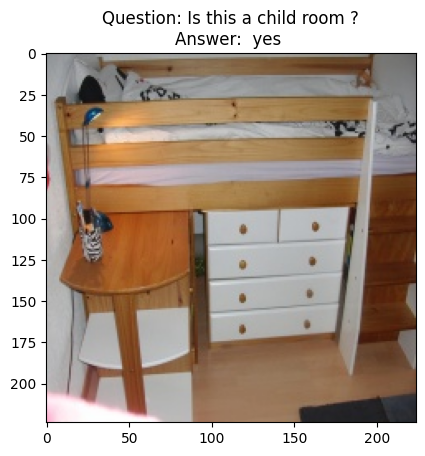

In [9]:
import matplotlib.pyplot as plt
image, question, label = val_dataset.__getone__(2)
plt.imshow(image)
plt.title(f"Question: {question}\nAnswer:  {label} ")
plt.savefig('./png/vqa_tr0.png')

In [7]:
def save_result(train_losses, train_accs, val_losses, val_accs, typo):
    f = open('./results/train_loss_{}.txt'.format(typo), 'w')
    f.write(str(train_losses))
    f.close()
    
    f = open('./results/valid_loss_{}.txt'.format(typo), 'w')
    f.write(str(val_losses))
    f.close()
    
    f = open('./results/train_acc_{}.txt'.format(typo), 'w')
    f.write(str(train_accs))
    f.close()
    
    f = open('./results/valid_acc_{}.txt'.format(typo), 'w')
    f.write(str(val_accs))
    f.close()

In [8]:
epochs = 20
lr = 1e-2
weight_decay = 1e-5
scheduler_step_size = epochs *0.6
criterion = nn.CrossEntropyLoss()

In [9]:

#model, train_loader, val_loader, test_loader, val_dataset = main(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters())
scheduler = None
typo = 'ControlLR' 
#ok: c=1.0001, c=1.00005 c=1.00001/ not: c=1.001 c=1.0005
optimizer = ControlLR(model.parameters(),  optimizer, model, criterion, c=1+5e-5)#best 1.00005


# train model
modn = 'vit'
train_losses, train_accs, val_losses, val_accs = trainer.fit(model, train_loader, val_loader, criterion, 
                                         optimizer, scheduler, device, epochs, modn, typo)
  
save_result(train_losses, train_accs, val_losses, val_accs, typo)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
61it [01:32,  1.52s/it]


Save model
Epoch 1:	Train loss: 0.7018	Train accuracy: 0.5208	Val loss: 0.6822	Val accuracy: 0.5692


61it [01:31,  1.50s/it]


Save model
Epoch 2:	Train loss: 0.6654	Train accuracy: 0.5983	Val loss: 0.6675	Val accuracy: 0.5871


61it [01:31,  1.50s/it]


Save model
Epoch 3:	Train loss: 0.6284	Train accuracy: 0.6473	Val loss: 0.6424	Val accuracy: 0.6270


61it [01:31,  1.50s/it]


Save model
Epoch 4:	Train loss: 0.5738	Train accuracy: 0.7070	Val loss: 0.6375	Val accuracy: 0.6445


61it [01:31,  1.50s/it]


Save model
Epoch 5:	Train loss: 0.4948	Train accuracy: 0.7629	Val loss: 0.6195	Val accuracy: 0.6783


61it [01:31,  1.51s/it]


Save model
Epoch 6:	Train loss: 0.4322	Train accuracy: 0.8084	Val loss: 0.6310	Val accuracy: 0.6808


61it [01:31,  1.51s/it]


Save model
Epoch 7:	Train loss: 0.3785	Train accuracy: 0.8390	Val loss: 0.6424	Val accuracy: 0.6814


61it [01:31,  1.50s/it]


Save model
Epoch 8:	Train loss: 0.3434	Train accuracy: 0.8522	Val loss: 0.6451	Val accuracy: 0.6972


61it [01:31,  1.50s/it]


Epoch 9:	Train loss: 0.3084	Train accuracy: 0.8737	Val loss: 0.6764	Val accuracy: 0.6875


61it [01:32,  1.51s/it]


Epoch 10:	Train loss: 0.2861	Train accuracy: 0.8806	Val loss: 0.6876	Val accuracy: 0.6916


61it [01:31,  1.50s/it]


Epoch 11:	Train loss: 0.2700	Train accuracy: 0.8887	Val loss: 0.7179	Val accuracy: 0.6931


61it [01:31,  1.50s/it]


Epoch 12:	Train loss: 0.2600	Train accuracy: 0.8927	Val loss: 0.7284	Val accuracy: 0.6880


61it [01:31,  1.50s/it]


Save model
Epoch 13:	Train loss: 0.2464	Train accuracy: 0.8984	Val loss: 0.7064	Val accuracy: 0.7049


61it [01:31,  1.51s/it]


Epoch 14:	Train loss: 0.2366	Train accuracy: 0.8978	Val loss: 0.7155	Val accuracy: 0.6967


61it [01:31,  1.50s/it]


Save model
Epoch 15:	Train loss: 0.2312	Train accuracy: 0.9024	Val loss: 0.7191	Val accuracy: 0.7080


61it [01:31,  1.50s/it]


Epoch 16:	Train loss: 0.2222	Train accuracy: 0.9070	Val loss: 0.7368	Val accuracy: 0.6972


61it [01:31,  1.51s/it]


Epoch 17:	Train loss: 0.2222	Train accuracy: 0.9059	Val loss: 0.7540	Val accuracy: 0.6947


61it [01:31,  1.51s/it]


Epoch 18:	Train loss: 0.2153	Train accuracy: 0.9087	Val loss: 0.7346	Val accuracy: 0.7080


61it [01:31,  1.50s/it]


Epoch 19:	Train loss: 0.2081	Train accuracy: 0.9099	Val loss: 0.7721	Val accuracy: 0.6998


61it [01:31,  1.51s/it]

Epoch 20:	Train loss: 0.1989	Train accuracy: 0.9151	Val loss: 0.7767	Val accuracy: 0.6988


In [10]:

typo = 'StepLR' 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)



# train model
modn = 'basic'
train_losses, train_accs, val_losses, val_accs = trainer.fit(model, train_loader, val_loader, criterion, 
                                         optimizer, scheduler, device, epochs, modn, typo)
  
save_result(train_losses, train_accs, val_losses, val_accs, typo)

Training: 100%|█████████████████████| 62/62 [06:22<00:00,  6.17s/it, loss=0.698]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 1:	Train loss: 0.7038	Train accuracy: 0.5199	Val loss: 0.6818	Val accuracy: 0.5717


Training: 100%|██████████████████████| 62/62 [06:24<00:00,  6.20s/it, loss=0.68]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 2:	Train loss: 0.6659	Train accuracy: 0.6007	Val loss: 0.6677	Val accuracy: 0.5948


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.641]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 3:	Train loss: 0.6311	Train accuracy: 0.6415	Val loss: 0.6571	Val accuracy: 0.6101


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.565]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 4:	Train loss: 0.5713	Train accuracy: 0.7010	Val loss: 0.6282	Val accuracy: 0.6455


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.548]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 5:	Train loss: 0.4987	Train accuracy: 0.7601	Val loss: 0.6298	Val accuracy: 0.6660


Training: 100%|█████████████████████| 62/62 [06:24<00:00,  6.19s/it, loss=0.575]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 6:	Train loss: 0.4306	Train accuracy: 0.8022	Val loss: 0.6560	Val accuracy: 0.6793


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.496]
61it [01:32,  1.51s/it]


Epoch 7:	Train loss: 0.3793	Train accuracy: 0.8351	Val loss: 0.6610	Val accuracy: 0.6706


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.343]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 8:	Train loss: 0.3369	Train accuracy: 0.8607	Val loss: 0.6596	Val accuracy: 0.6942


Training: 100%|█████████████████████| 62/62 [06:24<00:00,  6.20s/it, loss=0.418]
61it [01:32,  1.51s/it]


Epoch 9:	Train loss: 0.3103	Train accuracy: 0.8705	Val loss: 0.6959	Val accuracy: 0.6742


Training: 100%|█████████████████████| 62/62 [06:24<00:00,  6.20s/it, loss=0.322]
61it [01:32,  1.51s/it]


Save checkpoint
Epoch 10:	Train loss: 0.2893	Train accuracy: 0.8787	Val loss: 0.6943	Val accuracy: 0.6967


Training: 100%|█████████████████████| 62/62 [06:23<00:00,  6.19s/it, loss=0.317]
61it [01:32,  1.51s/it]


Epoch 11:	Train loss: 0.2662	Train accuracy: 0.8912	Val loss: 0.7102	Val accuracy: 0.6947


Training: 100%|█████████████████████| 62/62 [06:24<00:00,  6.20s/it, loss=0.334]
61it [01:31,  1.51s/it]


Save checkpoint
Epoch 12:	Train loss: 0.2534	Train accuracy: 0.8951	Val loss: 0.7157	Val accuracy: 0.6988


Training: 100%|█████████████████████| 62/62 [06:20<00:00,  6.14s/it, loss=0.207]
61it [01:31,  1.50s/it]


Save checkpoint
Epoch 13:	Train loss: 0.1889	Train accuracy: 0.9251	Val loss: 0.7032	Val accuracy: 0.7070


Training: 100%|█████████████████████| 62/62 [06:21<00:00,  6.15s/it, loss=0.216]
61it [01:31,  1.50s/it]


Save checkpoint
Epoch 14:	Train loss: 0.1686	Train accuracy: 0.9331	Val loss: 0.7130	Val accuracy: 0.7080


Training: 100%|██████████████████████| 62/62 [06:20<00:00,  6.14s/it, loss=0.18]
61it [01:31,  1.50s/it]


Epoch 15:	Train loss: 0.1610	Train accuracy: 0.9318	Val loss: 0.7249	Val accuracy: 0.7029


Training: 100%|█████████████████████| 62/62 [06:20<00:00,  6.14s/it, loss=0.157]
61it [01:31,  1.50s/it]


Epoch 16:	Train loss: 0.1547	Train accuracy: 0.9331	Val loss: 0.7274	Val accuracy: 0.7065


Training: 100%|█████████████████████| 62/62 [06:20<00:00,  6.13s/it, loss=0.101]
61it [01:31,  1.50s/it]


Epoch 17:	Train loss: 0.1494	Train accuracy: 0.9358	Val loss: 0.7361	Val accuracy: 0.7024


Training: 100%|█████████████████████| 62/62 [06:21<00:00,  6.15s/it, loss=0.152]
61it [01:31,  1.50s/it]


Epoch 18:	Train loss: 0.1460	Train accuracy: 0.9341	Val loss: 0.7454	Val accuracy: 0.7044


Training: 100%|█████████████████████| 62/62 [06:21<00:00,  6.15s/it, loss=0.202]
61it [01:31,  1.50s/it]


Epoch 19:	Train loss: 0.1463	Train accuracy: 0.9327	Val loss: 0.7512	Val accuracy: 0.7044


Training: 100%|█████████████████████| 62/62 [06:21<00:00,  6.15s/it, loss=0.214]
61it [01:31,  1.50s/it]

Epoch 20:	Train loss: 0.1448	Train accuracy: 0.9309	Val loss: 0.7583	Val accuracy: 0.7029


In [12]:

typo = 'ExponentialLR' 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

# train model
modn = 'vit'
train_losses, train_accs, val_losses, val_accs = trainer.fit(model, train_loader, val_loader, criterion, 
                                         optimizer, scheduler, device, epochs, modn, typo)
  
save_result(train_losses, train_accs, val_losses, val_accs, typo)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
61it [01:32,  1.52s/it]


Save model
Epoch 1:	Train loss: 0.7022	Train accuracy: 0.5196	Val loss: 0.6764	Val accuracy: 0.5927


61it [01:31,  1.50s/it]


Save model
Epoch 2:	Train loss: 0.6608	Train accuracy: 0.6066	Val loss: 0.6588	Val accuracy: 0.6050


61it [01:32,  1.52s/it]


Save model
Epoch 3:	Train loss: 0.6248	Train accuracy: 0.6518	Val loss: 0.6578	Val accuracy: 0.6086


61it [01:32,  1.51s/it]


Save model
Epoch 4:	Train loss: 0.5637	Train accuracy: 0.7079	Val loss: 0.6362	Val accuracy: 0.6311


61it [01:31,  1.50s/it]


Save model
Epoch 5:	Train loss: 0.4920	Train accuracy: 0.7735	Val loss: 0.6123	Val accuracy: 0.6757


61it [01:31,  1.50s/it]


Epoch 6:	Train loss: 0.4148	Train accuracy: 0.8205	Val loss: 0.6276	Val accuracy: 0.6675


61it [01:31,  1.51s/it]


Save model
Epoch 7:	Train loss: 0.3559	Train accuracy: 0.8462	Val loss: 0.6253	Val accuracy: 0.6983


61it [01:31,  1.51s/it]


Save model
Epoch 8:	Train loss: 0.3176	Train accuracy: 0.8674	Val loss: 0.6219	Val accuracy: 0.7039


61it [01:31,  1.50s/it]


Epoch 9:	Train loss: 0.2857	Train accuracy: 0.8812	Val loss: 0.6447	Val accuracy: 0.6957


61it [01:31,  1.51s/it]


Epoch 10:	Train loss: 0.2505	Train accuracy: 0.8979	Val loss: 0.6603	Val accuracy: 0.7003


61it [01:32,  1.51s/it]


Epoch 11:	Train loss: 0.2319	Train accuracy: 0.9039	Val loss: 0.6621	Val accuracy: 0.7034


61it [01:31,  1.51s/it]


Save model
Epoch 12:	Train loss: 0.2167	Train accuracy: 0.9107	Val loss: 0.6788	Val accuracy: 0.7065


61it [01:31,  1.50s/it]


Epoch 13:	Train loss: 0.2034	Train accuracy: 0.9129	Val loss: 0.6917	Val accuracy: 0.7013


61it [01:32,  1.51s/it]


Epoch 14:	Train loss: 0.1902	Train accuracy: 0.9155	Val loss: 0.7007	Val accuracy: 0.7018


61it [01:31,  1.51s/it]


Epoch 15:	Train loss: 0.1838	Train accuracy: 0.9192	Val loss: 0.7306	Val accuracy: 0.6983


61it [01:32,  1.52s/it]


Epoch 16:	Train loss: 0.1752	Train accuracy: 0.9258	Val loss: 0.7315	Val accuracy: 0.7008


61it [01:32,  1.52s/it]


Epoch 17:	Train loss: 0.1664	Train accuracy: 0.9239	Val loss: 0.7338	Val accuracy: 0.6931


61it [01:32,  1.52s/it]


Epoch 18:	Train loss: 0.1591	Train accuracy: 0.9272	Val loss: 0.7383	Val accuracy: 0.7044


61it [01:33,  1.53s/it]


Epoch 19:	Train loss: 0.1560	Train accuracy: 0.9275	Val loss: 0.7532	Val accuracy: 0.6926


61it [01:32,  1.52s/it]

Epoch 20:	Train loss: 0.1501	Train accuracy: 0.9294	Val loss: 0.7552	Val accuracy: 0.6936


# Plotter

In [20]:
import matplotlib.pyplot as plt
import re
import numpy as np
import csv

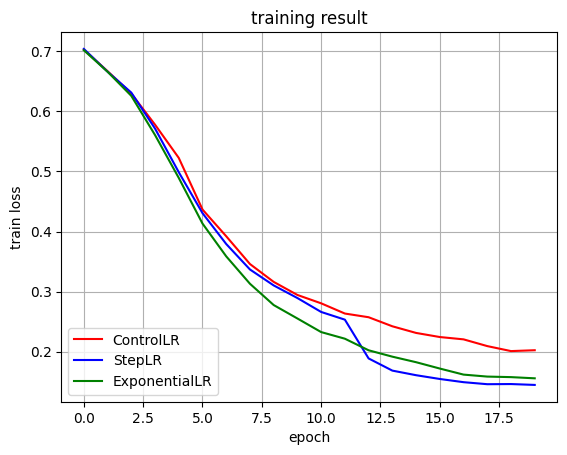

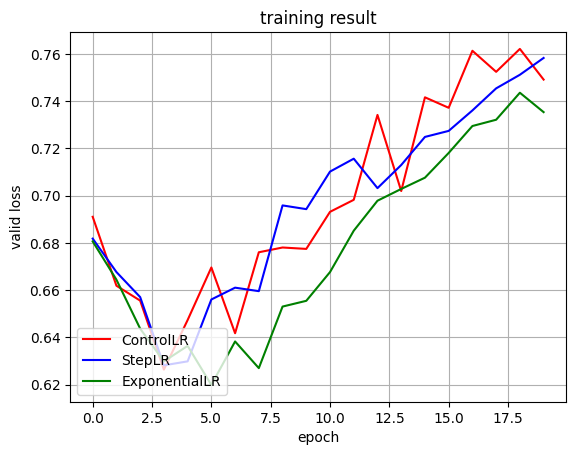

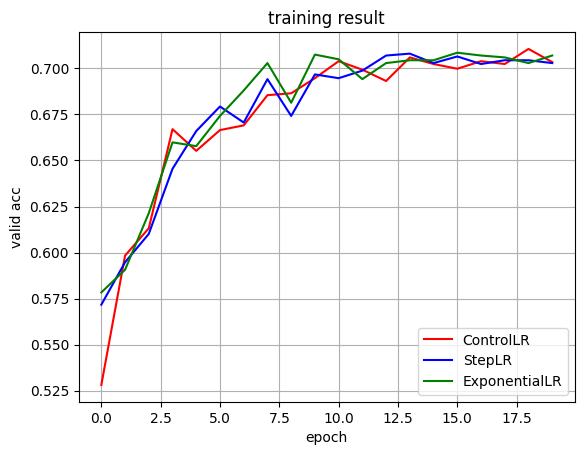

In [27]:
#fig = plt.figure(figsize=(10,5))

def read(name):
    f = open(name, 'r')
    file = f.read()
    file = re.sub('\\[', '', file)
    file = re.sub('\\]', '', file)
    f.close()

    return [float(i) for idx, i in enumerate(file.split(','))]


def draw(mode):
        
    if mode == 'train loss':
        clr = read('./results/train_loss_ControlLR.txt')
        adam = read('./results/train_loss_StepLR.txt')
        ExponentialLR = read('./results/train_loss_ExponentialLR.txt')
        plt.plot(clr, 'r', label='ControlLR')
        plt.plot(adam, 'b', label='StepLR')
        plt.plot(ExponentialLR, 'g', label='ExponentialLR')
        plt.legend(loc='lower left')

    elif mode == 'valid loss':
        clr = read('./results/valid_loss_ControlLR.txt')
        adam = read('./results/valid_loss_StepLR.txt')
        ExponentialLR = read('./results/valid_loss_ExponentialLR.txt')
        plt.plot(clr, 'r', label='ControlLR')
        plt.plot(adam, 'b', label='StepLR')
        plt.plot(ExponentialLR, 'g', label='ExponentialLR')
        plt.legend(loc='lower left')
  
    elif mode == 'train acc':
        clr = read('./results/train_acc_ControlLR.txt')
        adam = read('./results/train_acc_StepLR.txt')
        plt.plot(clr, 'r', label='CLR')
        plt.plot(ExponentialLR, 'b', label='Adam')
        plt.legend(loc='best')

    elif mode == 'valid acc':
        clr = read('./results/valid_acc_ControlLR.txt')
        adam = read('./results/valid_acc_StepLR.txt')
        ExponentialLR = read('./results/valid_acc_ExponentialLR.txt')
        plt.plot(clr, 'r', label='ControlLR')
        plt.plot(adam, 'b', label='StepLR')
        plt.plot(ExponentialLR, 'g', label='ExponentialLR')
        plt.legend(loc='best')
        
    plt.xlabel('epoch')
    plt.ylabel(mode)
    plt.title('training result')
    plt.grid(True, which='both', axis='both')
    plt.savefig('./png/{}.png'.format(mode))
    plt.show()

draw(mode='train loss')
draw(mode='valid loss')
    
#draw(mode='train acc')
draw(mode='valid acc')    
